### 1) Qiskit - TSP

In [1]:
# https://qiskit-community.github.io/qiskit-optimization/tutorials/06_examples_max_cut_and_tsp.html

In [2]:
! pip install qiskit_optimization

In [3]:
import pennylane as qml

from pennylane import qaoa
from pennylane import numpy as np

import networkx as nx

from itertools import permutations

from qiskit_optimization.applications import Tsp

from qiskit_optimization.converters import QuadraticProgramToQubo

import matplotlib.pyplot as plt


## Introduction: Solving the Traveling Salesman Problem

Consider the task of finding the shortest cycle within a graph $G=(V,E)$, where $V$ represents the set of nodes with $n=|V|$ elements and $w_{ij}$ signifies the distance between vertex $i$ and vertex $j$. 

### Mathematical Formulation

A  cycle is characterized by $N^2$ variables $x_{i,p}$, where $i$ denotes the node and $p$ denotes its position in the prospective cycle. Each decision variable takes a value of 1 if the solution involves node $i$ at time step $p$. 

Constraints are imposed to ensure that each node appears exactly once in the cycle, and at each time step, a node must be visited. These constraints can be succinctly represented as:

$$\sum_{i} x_{i,p} = 1 ~~\forall p$$
$$\sum_{p} x_{i,p} = 1 ~~\forall i.$$

### Node Connectivity Considerations

Within the prospective ordering of nodes, a penalty is incurred if both $x_{i,p}$ and $x_{j,p+1}$ are set to 1 but nodes $i$ and $j$ are not connected in the graph ($i,j \notin E$). This penalty, representing the lack of connectivity, is mathematically expressed as:

$$\sum_{i,j\notin E}\sum_{p} x_{i,p}x_{j,p+1}>0.$$

For simplicity, we assume a fully connected graph, thus omitting this penalty term.

### Objective Function

Minimization of the distance traveled along the Hamiltonian cycle is the primary objective. The distance function $C(\textbf{x})$ is given by:

$$C(\textbf{x})=\sum_{i,j}w_{ij}\sum_{p} x_{i,p}x_{j,p+1}.$$

To unify constraints and the objective function, we introduce a single objective function to minimize:

$$C(\textbf{x})=\sum_{i,j}w_{ij}\sum_{p} x_{i,p}x_{j,p+1}+ A\sum_p\left(1- \sum_i x_{i,p}\right)^2+A\sum_i\left(1- \sum_p x_{i,p}\right)^2,$$

where $A$ serves as a free parameter ensuring constraint satisfaction. Setting $A > \mathrm{max}(w_{ij})$ guarantees constraint enforcement.

## Helper Functions to visualize the graph

In [4]:
def draw_graph(graph, colors, positions):
    """
    Draw a graph with nodes colored according to specified colors and labeled with edge weights.

    Args:
        graph (nx.Graph): The graph to be drawn.
        colors (list): List of node colors.
        positions (dict): Dictionary mapping nodes to their positions.

    Returns:
        None
    """
    default_axes = plt.axes(frameon=True)
    
    # Draw the networkx graph
    nx.draw_networkx(graph, 
                     pos=positions,
                     ax=default_axes,
                     node_color=colors, 
                     node_size=600, 
                     alpha=0.8)
    
    # Get edge labels
    edge_labels = nx.get_edge_attributes(graph, "weight")
    
    # Draw edge labels
    nx.draw_networkx_edge_labels(graph,
                                 pos=positions, 
                                 edge_labels=edge_labels)



In [5]:
def draw_tsp_solution(graph, order, colors, positions):
    """
    Draw a solution for the Traveling Salesman Problem (TSP).

    Args:
        graph (nx.Graph): The graph representing the TSP.
        order (tuple): The order of nodes to visit.
        colors (list): List of node colors.
        positions (dict): Dictionary mapping nodes to their positions.

    Returns:
        None
    """
    digraph = nx.DiGraph()
    digraph.add_nodes_from(graph)
    graph_size = len(order)
    
    # Add edges to the directed graph based on the order of nodes
    for index_a in range(graph_size):
        index_b = (index_a + 1) % graph_size
        node_a = order[index_a]
        node_b = order[index_b]
        weight = graph[node_a][node_b]["weight"]
        digraph.add_edge(node_a, node_b, weight=weight)
        
    default_axes = plt.axes(frameon=True)
    
    # Draw the directed graph
    nx.draw_networkx(
        digraph,
        pos=positions,
        ax=default_axes,
        node_color=colors, 
        edge_color="b", 
        node_size=600, 
        alpha=0.8)
    
    # Get edge labels
    edge_labels = nx.get_edge_attributes(digraph, "weight")
    
    # Draw edge labels
    nx.draw_networkx_edge_labels(
        digraph, 
        positions, 
        font_color="b", 
        edge_labels=edge_labels)


## Create a random instance of a graph

In [6]:
# Random Graph

NODES_COUNT = 3

qubits_count = NODES_COUNT ** 2

tsp = Tsp.create_random_instance(NODES_COUNT, seed=123)

graph = tsp.graph

distances = nx.to_numpy_array(graph)

print("distances:")
print(distances)

distances:
[[ 0. 48. 91.]
 [48.  0. 63.]
 [91. 63.  0.]]


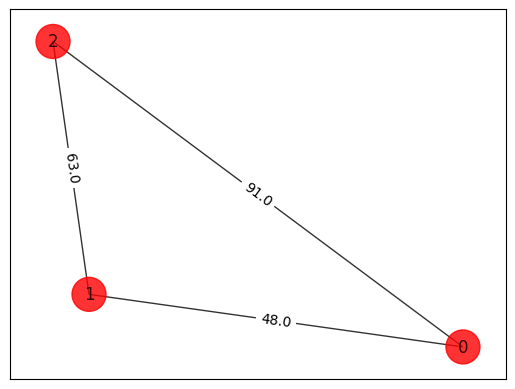

In [7]:
# Graph

colors = ["r" for node in graph.nodes]

positions = [tsp.graph.nodes[node]["pos"] for node in graph.nodes]

draw_graph(graph, colors, positions)

## Solve TSP classically with brute force method

In [8]:
def brute_force_tsp(distances, nodes_count):
    """
    Solve the Traveling Salesman Problem (TSP) using brute force.

    Args:
        distances (dict): Dictionary containing distances between nodes.
        nodes_count (int): Number of nodes in the graph.

    Returns:
        tuple: A tuple containing the best order of nodes to visit and the corresponding distance.
    """
    nodes_permutations = list(permutations(range(1, nodes_count)))
    best_distance = float('inf')
    
    # Iterate through all permutations of nodes
    for nodes in nodes_permutations:
        nodes_a = (0,) + nodes
        nodes_b = nodes + (0,)
        
        node_pairs = list(zip(nodes_a, nodes_b))
        
        # Calculate the distance for the current order of nodes
        distance = sum(distances[node_a, node_b] for node_a, node_b in node_pairs)
        
        order = (0,) + nodes
        
        # Update the best distance and order if the current distance is shorter
        if distance < best_distance:
            best_order = order
            best_distance = distance
            
    return best_order, best_distance 

In [9]:
# Brute Force

best_order, best_distance = brute_force_tsp(distances, NODES_COUNT)

print("best_order:", best_order)
print("best_distance:", best_distance)

best_order: (0, 1, 2)
best_distance: 202.0


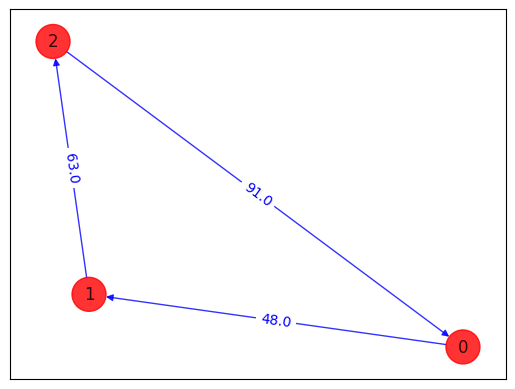

In [10]:
draw_tsp_solution(graph, best_order, colors, positions)

## QUBO formulation of the problem

In [11]:
quadratic_program = tsp.to_quadratic_program()

print(quadratic_program.prettyprint())

Problem name: TSP

Minimize
  48*x_0_0*x_1_1 + 48*x_0_0*x_1_2 + 91*x_0_0*x_2_1 + 91*x_0_0*x_2_2
  + 48*x_0_1*x_1_0 + 48*x_0_1*x_1_2 + 91*x_0_1*x_2_0 + 91*x_0_1*x_2_2
  + 48*x_0_2*x_1_0 + 48*x_0_2*x_1_1 + 91*x_0_2*x_2_0 + 91*x_0_2*x_2_1
  + 63*x_1_0*x_2_1 + 63*x_1_0*x_2_2 + 63*x_1_1*x_2_0 + 63*x_1_1*x_2_2
  + 63*x_1_2*x_2_0 + 63*x_1_2*x_2_1

Subject to
  Linear constraints (6)
    x_0_0 + x_0_1 + x_0_2 == 1  'c0'
    x_1_0 + x_1_1 + x_1_2 == 1  'c1'
    x_2_0 + x_2_1 + x_2_2 == 1  'c2'
    x_0_0 + x_1_0 + x_2_0 == 1  'c3'
    x_0_1 + x_1_1 + x_2_1 == 1  'c4'
    x_0_2 + x_1_2 + x_2_2 == 1  'c5'

  Binary variables (9)
    x_0_0 x_0_1 x_0_2 x_1_0 x_1_1 x_1_2 x_2_0 x_2_1 x_2_2



In [12]:
# # QUBO Matrix

# constant = quadratic_program.objective.constant

# linear = quadratic_program.objective.linear.to_array()

# quadratic = quadratic_program.objective.quadratic.to_array()

# qubo_matrix = quadratic + np.diag(linear) + constant

# qubo_matrix.astype(int)

In [13]:
converter = QuadraticProgramToQubo()

qubo = converter.convert(quadratic_program)

tsp_qiskit_hamiltonian, offset = qubo.to_ising()

print("offset:", offset)
# print("tsp_qiskit_hamiltonian:")
# print(str(tsp_qiskit_hamiltonian))

offset: 7581.0


## Qiskit to Pennylane Hamiltonian

In [14]:
# https://discuss.pennylane.ai/t/problem-with-hamiltonian-from-qiskit-to-pennylane/3682/7

In [15]:
def qiskit_to_pennylane_hamiltonian(qiskit_hamiltonian):
      
    pauli_list, coefficients = qiskit_hamiltonian.paulis, qiskit_hamiltonian.coeffs

    pauli_list = [p.to_label() for p in pauli_list] # Convert Pauli(str) objects to str
    coefficients = [c.real for c in coefficients] # Convert numpy floats to python floats

        
    print("qiskit pauli_list:", pauli_list)
    print("qiskit coefficients:", coefficients)

    # Qiskit Little endian to Pennylane Big endian mapping
    
    wire_map = {}
    
    qubits_count = qiskit_hamiltonian.num_qubits
    
    for qubit in range(qubits_count):
        
        wire_map[qubits_count - qubit - 1] = qubit 
        
    # Pennylane Hamiltonian
    pauli_operations = [qml.pauli.string_to_pauli_word(word, wire_map=wire_map) 
                        for word in pauli_list]
    
    pennylane_hamiltonian = qml.Hamiltonian(coefficients, pauli_operations)
    
    print("pennylane_hamiltonian:", pennylane_hamiltonian)
    
    return pennylane_hamiltonian 

In [16]:
tsp_pennylane_hamiltonian = qiskit_to_pennylane_hamiltonian(tsp_qiskit_hamiltonian)

qiskit pauli_list: ['IIIIIIIIZ', 'IIIIIIIZI', 'IIIIIIZII', 'IIIIIZIII', 'IIIIZIIII', 'IIIZIIIII', 'IIZIIIIII', 'IZIIIIIII', 'ZIIIIIIII', 'IIIIIIIZZ', 'IIIIIIZIZ', 'IIIIIZIIZ', 'IIIIZIIIZ', 'IIIZIIIIZ', 'IIZIIIIIZ', 'IZIIIIIIZ', 'ZIIIIIIIZ', 'IIIIIIZZI', 'IIIIIZIZI', 'IIIIZIIZI', 'IIIZIIIZI', 'IIZIIIIZI', 'IZIIIIIZI', 'ZIIIIIIZI', 'IIIIIZZII', 'IIIIZIZII', 'IIIZIIZII', 'IIZIIIZII', 'IZIIIIZII', 'ZIIIIIZII', 'IIIIZZIII', 'IIIZIZIII', 'IIZIIZIII', 'IZIIIZIII', 'ZIIIIZIII', 'IIIZZIIII', 'IIZIZIIII', 'IZIIZIIII', 'ZIIIZIIII', 'IIZZIIIII', 'IZIZIIIII', 'ZIIZIIIII', 'IZZIIIIII', 'ZIZIIIIII', 'ZZIIIIIII']
qiskit coefficients: [-1282.5, -1282.5, -1282.5, -1268.5, -1268.5, -1268.5, -1290.0, -1290.0, -1290.0, 606.5, 606.5, 606.5, 12.0, 12.0, 606.5, 22.75, 22.75, 606.5, 12.0, 606.5, 12.0, 22.75, 606.5, 22.75, 12.0, 12.0, 606.5, 22.75, 22.75, 606.5, 606.5, 606.5, 606.5, 15.75, 15.75, 606.5, 15.75, 606.5, 15.75, 15.75, 15.75, 606.5, 606.5, 606.5, 606.5]
pennylane_hamiltonian:   (-1290.0) [Z6]
+ (-12

the smallest eigenvalue: -7379.0


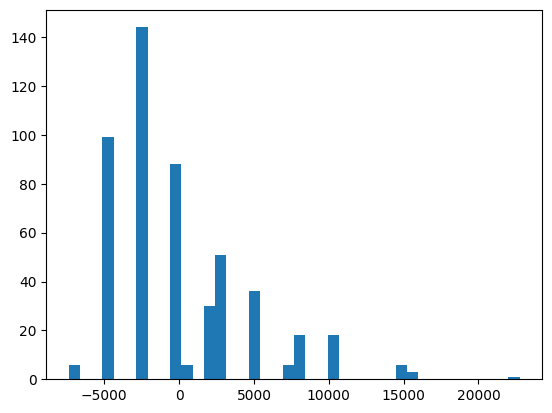

In [17]:
# eigenvalues = np.diag(qml.matrix(tsp_pennylane_hamiltonian))
eigenvalues = np.linalg.eigvals(qml.matrix(tsp_pennylane_hamiltonian))
print("the smallest eigenvalue:", min(eigenvalues.real))

#plot histogram of the eigenvalues
plt.hist(eigenvalues.real, bins=40)
plt.show()

## Solve TSP with pennylane

In [18]:
tsp_pennylane_hamiltonian

<Hamiltonian: terms=45, wires=[0, 1, 2, 3, 4, 5, 6, 7, 8]>


In [19]:
def get_mixer_hamiltonian(qubits_count):
    """
    Constructs the mixer Hamiltonian for the QAOA circuit.

    This function generates a mixer Hamiltonian composed of Pauli-X observables
    acting on each qubit with uniform coefficients.

    Args:
        qubits_count (int): Number of qubits in the system.

    Returns:
        qml.Hamiltonian: Mixer Hamiltonian for the QAOA circuit.
    """
    coefficients = [1] * qubits_count
    observables = [qml.PauliX(qubit) for qubit in range(qubits_count)]
    
    mixer_hamiltonian = qml.Hamiltonian(
        coeffs=coefficients,
        observables=observables
    )
    
    return mixer_hamiltonian

In [20]:
cost_hamiltonian = tsp_pennylane_hamiltonian
mixer_hamiltonian = get_mixer_hamiltonian(qubits_count)

print("Cost Hamiltonian:", cost_hamiltonian)
print("Mixer Hamiltonian:", mixer_hamiltonian)

Cost Hamiltonian:   (-1290.0) [Z6]
+ (-1290.0) [Z7]
+ (-1290.0) [Z8]
+ (-1282.5) [Z0]
+ (-1282.5) [Z1]
+ (-1282.5) [Z2]
+ (-1268.5) [Z3]
+ (-1268.5) [Z4]
+ (-1268.5) [Z5]
+ (12.0) [Z4 Z0]
+ (12.0) [Z5 Z0]
+ (12.0) [Z3 Z1]
+ (12.0) [Z5 Z1]
+ (12.0) [Z3 Z2]
+ (12.0) [Z4 Z2]
+ (15.75) [Z7 Z3]
+ (15.75) [Z8 Z3]
+ (15.75) [Z6 Z4]
+ (15.75) [Z8 Z4]
+ (15.75) [Z6 Z5]
+ (15.75) [Z7 Z5]
+ (22.75) [Z7 Z0]
+ (22.75) [Z8 Z0]
+ (22.75) [Z6 Z1]
+ (22.75) [Z8 Z1]
+ (22.75) [Z6 Z2]
+ (22.75) [Z7 Z2]
+ (606.5) [Z1 Z0]
+ (606.5) [Z2 Z0]
+ (606.5) [Z3 Z0]
+ (606.5) [Z6 Z0]
+ (606.5) [Z2 Z1]
+ (606.5) [Z4 Z1]
+ (606.5) [Z7 Z1]
+ (606.5) [Z5 Z2]
+ (606.5) [Z8 Z2]
+ (606.5) [Z4 Z3]
+ (606.5) [Z5 Z3]
+ (606.5) [Z6 Z3]
+ (606.5) [Z5 Z4]
+ (606.5) [Z7 Z4]
+ (606.5) [Z8 Z5]
+ (606.5) [Z7 Z6]
+ (606.5) [Z8 Z6]
+ (606.5) [Z8 Z7]
Mixer Hamiltonian:   (1) [X0]
+ (1) [X1]
+ (1) [X2]
+ (1) [X3]
+ (1) [X4]
+ (1) [X5]
+ (1) [X6]
+ (1) [X7]
+ (1) [X8]


In [21]:
QAOA_LAYERS_COUNT = 4
VQE_LAYERS_COUNT = 4

STEPS_COUNT = 300

np.random.seed(2)
qubits_count = len(tsp_pennylane_hamiltonian.wires)

qubits = list(range(qubits_count))

qml_device = qml.device("default.qubit", wires=qubits)

## QAOA 

In [22]:
# Functions
def qaoa_layer(gamma, alpha):
    """
    Builds a single layer of the Quantum Approximate Optimization Algorithm (QAOA) circuit.

    Args:
        gamma (float): The parameter for the cost layer.
        alpha (float): The parameter for the mixer layer.

    Returns:
        None
    """
    qaoa.cost_layer(gamma, cost_hamiltonian)
    qaoa.mixer_layer(alpha, mixer_hamiltonian)


def qaoa_circuit(gammas, alphas):
    """
    Constructs the Quantum Approximate Optimization Algorithm (QAOA) circuit.

    This function builds the QAOA circuit by applying Hadamard gates to each qubit
    and then stacking QAOA layers composed of cost and mixer layers.

    Args:
        gammas (list): List of parameters for the cost layer.
        alphas (list): List of parameters for the mixer layer.

    Returns:
        None
    """
    for qubit in qubits:
        qml.Hadamard(wires=qubit)
        
    qml.layer(qaoa_layer, QAOA_LAYERS_COUNT, gammas, alphas)


@qml.qnode(qml_device)
def cost_function_qaoa(gammas, alphas):
    """
    Evaluates the cost function of the Quantum Approximate Optimization Algorithm (QAOA).

    This function constructs the QAOA circuit with the provided parameters and calculates
    the expectation value of the cost Hamiltonian.

    Args:
        gammas (list): List of parameters for the cost layer.
        alphas (list): List of parameters for the mixer layer.

    Returns:
        float: Expectation value of the cost Hamiltonian.
    """
    qaoa_circuit(gammas, alphas) 
    res = qml.expval(cost_hamiltonian)   
    return res

@qml.qnode(qml_device)
def sample_qaoa_probabilities(gammas, alphas):
    """
    Samples the probabilities of the Quantum Approximate Optimization Algorithm (QAOA) circuit outcomes.

    This function constructs the QAOA circuit with the provided parameters and returns
    the probability distribution of measurement outcomes.

    Args:
        gammas (list): List of parameters for the cost layer.
        alphas (list): List of parameters for the mixer layer.

    Returns:
        numpy.ndarray: Probability distribution of measurement outcomes.
    """
    qaoa_circuit(gammas, alphas)
    return qml.probs(wires=qubits)

## VQE code

In [23]:
def vqe_circuit(params):
    """
    Constructs the Variational Quantum Eigensolver (VQE) circuit.

    This function uses qml.StronglyEntanglingLayers to create a variational circuit
    with the specified number of layers and parameters.

    Args:
        params (list): List of variational parameters.
        nlayers (int): Number of layers in the circuit.

    Returns:
        None
    """
    qml.StronglyEntanglingLayers(weights=params, wires= qubits)
    

@qml.qnode(qml_device)
def cost_function_vqe(params):
    """
    Evaluates the cost function of the Variational Quantum Eigensolver (VQE).

    This function constructs the VQE circuit with the provided parameters and calculates
    the expectation value of the cost Hamiltonian.

    Args:
        params (list): List of variational parameters.

    Returns:
        float: Expectation value of the cost Hamiltonian.
    """
    vqe_circuit(params) 
    res = qml.expval(cost_hamiltonian)   
    return res

@qml.qnode(qml_device)
def sample_vqe_probabilities(params):
    """
    Samples the probabilities of the Variational Quantum Eigensolver (VQE) circuit outcomes.

    This function constructs the VQE circuit with the provided parameters and returns
    the probability distribution of measurement outcomes.

    Args:
        params (list): List of variational parameters.

    Returns:
        numpy.ndarray: Probability distribution of measurement outcomes.
    """
    vqe_circuit(params)
    return qml.probs(wires=qubits)

In [24]:
def get_mixer_hamiltonian(qubits_count):
    """
    Constructs the mixer Hamiltonian for the QAOA circuit.

    This function generates a mixer Hamiltonian composed of Pauli-X observables
    acting on each qubit with uniform coefficients.

    Args:
        qubits_count (int): Number of qubits in the system.

    Returns:
        qml.Hamiltonian: Mixer Hamiltonian for the QAOA circuit.
    """
    coefficients = [1] * qubits_count
    observables = [qml.PauliX(qubit) for qubit in range(qubits_count)]
    
    mixer_hamiltonian = qml.Hamiltonian(
        coeffs=coefficients,
        observables=observables
    )
    
    return mixer_hamiltonian

In [25]:
# optimizer = qml.SPSAOptimizer(maxiter=STEPS_COUNT)
optimizer = qml.AdamOptimizer()

In [26]:
# gammas = np.array([0.2] * QAOA_LAYERS_COUNT, requires_grad=True)
# alphas = np.array([0.2] * QAOA_LAYERS_COUNT, requires_grad=True)

# list_cost = []

# for step in range(STEPS_COUNT):
#     print(f"Step {step}/{STEPS_COUNT}", end="\r")
#     (gammas, alphas), curr_cost = optimizer.step_and_cost(cost_function_qaoa, gammas, alphas)
#     list_qaoa_cost.append(curr_cost)

# print("Optimal Parameters")
# print(gammas, alphas)

In [27]:
vqe_params_shape = qml.StronglyEntanglingLayers.shape(n_layers=VQE_LAYERS_COUNT, n_wires=qubits_count)
vqe_params = np.random.random(size=vqe_params_shape)

list_cost = []

for step in range(STEPS_COUNT):
    print(f"Step {step}/{STEPS_COUNT}", end="\r")
    vqe_params, curr_cost = optimizer.step_and_cost(cost_function_vqe, vqe_params)
    list_cost.append(curr_cost)

print("Optimal cost:", curr_cost)

Optimal cost: -6236.085932409262


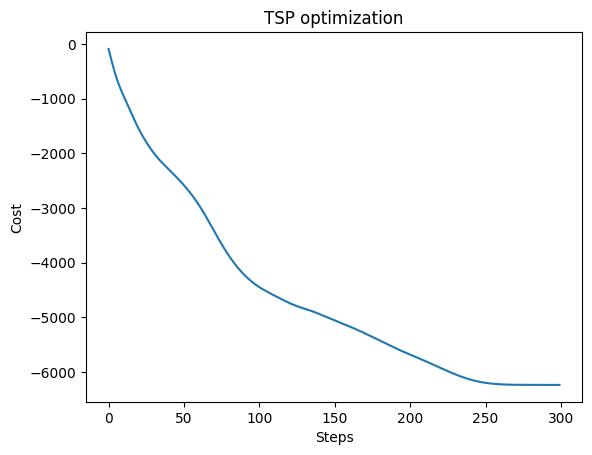

In [28]:
plt.plot(list_cost)
plt.xlabel("Steps")
plt.ylabel("Cost")
plt.title("TSP optimization")
plt.show()

In [29]:
# probabilities = sample_qaoa_probabilities(gammas, alphas)
probabilities = sample_vqe_probabilities(vqe_params)
probabilities.shape

(512,)

In [30]:
# States

states_count = 2 ** qubits_count

states = list(range(states_count))

label_pattern = f"0{qubits_count}b"

state_labels = [f"{state:{label_pattern}}" for state in states]

In [31]:
optimal_state_probabilities = dict(zip(state_labels, probabilities.tolist()))

In [32]:
sorted_optimal_probs = dict(sorted(optimal_state_probabilities.items(), 
                                         key=lambda item: -item[1]))

top_optimal_state_probs = dict(list(sorted_optimal_probs.items())[:10])

top_optimal_state_probs

{'001100010': 0.5005064395012012,
 '000010001': 0.4992605570481031,
 '000100000': 9.538799795465385e-05,
 '001010011': 8.362276752115731e-05,
 '100000011': 1.452676329745731e-05,
 '101110000': 1.4526435643589758e-05,
 '100100010': 1.2127259235881121e-05,
 '101010001': 1.2126973198739632e-05,
 '100100011': 2.5872221847532416e-07,
 '101010000': 2.5871328573414783e-07}

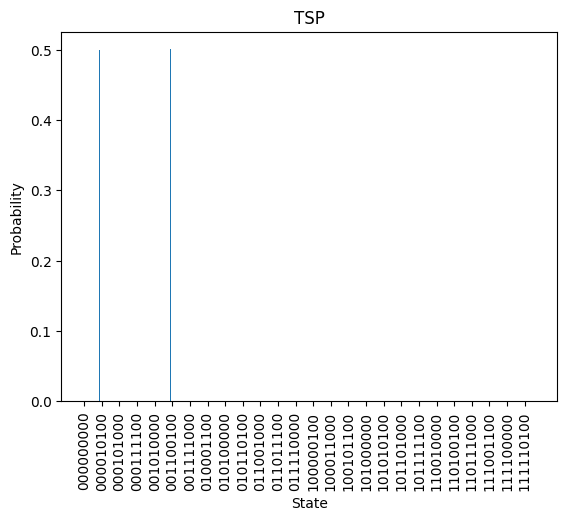

In [33]:
# Plot Results

TICK_PERIOD = 20

plt.title("TSP")
plt.xlabel("State")
plt.ylabel("Probability")

plt.bar(state_labels, probabilities)

plt.xticks(states[::TICK_PERIOD], 
           state_labels[::TICK_PERIOD], 
           rotation="vertical")

plt.show()